In [2]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
import tensorflow as tf
%matplotlib inline

tf.random.set_seed(0)

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

In [4]:
K.get_session()

In [5]:
import tensorflow.python.keras, math
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt
from pathlib import Path
import os

def save_weights(model, file):
    model.save_weights(file, overwrite=True)

def reset_weights(model, file):
    model.load_weights(file)
            

class CycleLearner(tensorflow.python.keras.callbacks.Callback):
    def __init__(self, lr, nb, n_cycle, cycle_len=1, cycle_mult=1,
                 snapshots=False, n_snapshots=5,
                 snapshots_name='temp_model', snapshots_folder='snapshots'):
        super().__init__()
        self.lr = lr
        self.nb = nb*cycle_len
        self.n_cycle = n_cycle
        self.cycle_len = cycle_len
        self.cycle_mult = cycle_mult
        self.snapshots = snapshots
        self.n_snapshots = n_snapshots
        self.start_snaps = n_cycle - n_snapshots
        self.snapshots_name = snapshots_name
        self.snapshots_folder = snapshots_folder
        self.lr_list = []
        self.losses = []
        self.iterations = []

        if not os.path.exists:
            os.mkdir(self.snapshots_folder, )
       
    def on_train_begin(self, logs={}):
        self.iteration,self.epoch = 0,0
        self.cycle_iter,self.cycle_count=0,0
        self.update_lr()
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1

    def on_batch_end(self, batch, logs={}):
        self.iteration += 1
        self.lr_list.append(K.eval(self.model.optimizer.lr))
        loss = logs.get('loss')
        self.losses.append(loss)
        self.iterations.append(self.iteration)
        self.update_lr()
        if self.cycle_count == self.n_cycle:
            self.model.stop_training = True
    
    def on_cycle_end(self):
        self.cycle_iter = 0
        self.nb *= self.cycle_mult
        self.cycle_count += 1
        if self.snapshots and self.cycle_count>self.start_snaps:
            file = self.snapshots_folder +  '/'+ f'{self.snapshots_name}_{self.cycle_count}.hdf5'
            
            self.model.save_weights(file, overwrite=True)
    
    def update_lr(self):
        new_lr = self.calc_lr()
        K.set_value(self.model.optimizer.lr, new_lr)

    def calc_lr(self):
        if self.iteration<self.nb/20:
            self.cycle_iter += 1
            return self.lr/100.

        cos_out = np.cos(np.pi*(self.cycle_iter)/self.nb) + 1
        self.cycle_iter += 1
        if self.cycle_iter==self.nb:
            self.on_cycle_end()
            
        return self.lr / 2 * cos_out        
        
    def plot_loss(self, skip=10):
        plt.plot(self.iterations[skip:], self.losses[skip:])

    def plot_lr(self):
        plt.xlabel("iterations")
        plt.ylabel("learning rate")
        plt.plot(self.iterations, self.lr_list)


class LrFinder(tensorflow.python.keras.callbacks.Callback):
    def __init__(self, nb, start_lr=1e-5, end_lr=10):
        super().__init__()
        self.start_lr = start_lr
        self.lr = start_lr
        self.lr_mult = (end_lr/start_lr)**(1/nb)
        self.lr_list = []
        self.losses = []
        self.iterations = []
        self.derivatives = []
        
    def on_train_begin(self, logs={}):
        self.best = 1e9
        self.iteration = 0
        self.update_lr()

    def on_batch_end(self, batch, logs={}):
        self.iteration += 1
        self.lr_list.append(K.eval(self.model.optimizer.lr))
        loss = logs.get('loss')
        self.losses.append(loss)
        self.iterations.append(self.iteration)

        if math.isnan(loss) or loss>self.best*4:
            self.model.stop_training = True
        if loss<self.best:
            self.best=loss
        self.update_lr()
    
    def update_lr(self):
        new_lr = self.start_lr * (self.lr_mult**self.iteration)
        K.set_value(self.model.optimizer.lr, new_lr)
        
    def plot_loss(self):
        plt.plot(self.iterations[10:], self.losses[10:])

    def plot_lr(self):
        plt.xlabel("iterations")
        plt.ylabel("learning rate")
        plt.plot(self.iterations, self.lr_list)
        
    def plot(self, n_skip_start=2, xlim=None, ylim=None):
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lr_list[n_skip_start:], self.losses[n_skip_start:])
        plt.xscale('log')
        if ylim is not None: plt.ylim(top=ylim)
        if xlim is not None: plt.xlim(right=xlim)
        
    def plot_loss_variation(self, window_size=1, xlim_range=None, ylim_range=None):
        assert (window_size>0),

        self.derivatives = []
        self.lr_list_on_xlim = []
        for i in range(len(self.lr_list)-window_size):
            if  self.lr_list[i] < xlim_range[0]:
                continue
            if  self.lr_list[i] > xlim_range[1]:
                break
            derivative = (self.losses[i + window_size] - self.losses[i]) / window_size
            self.derivatives.append(derivative)
            self.lr_list_on_xlim.append(self.lr_list[i])
      
        plt.ylabel("d/loss")        
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lr_list_on_xlim, self.derivatives)
        plt.xscale('log')
        if ylim_range is not None: plt.ylim(ylim_range)
        if xlim_range is not None: plt.xlim(xlim_range)



Overwriting custom_callbacks.py


# MNIST

In [6]:
from tensorflow.python.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f'Train -> x: {x_train.shape}')
print(f'         y: {y_train.shape}')
print(f'Test -> x: {x_test.shape}')
print(f'        y: {y_test.shape}')

Train -> x: (60000, 28, 28)
         y: (60000,)
Test -> x: (10000, 28, 28)
        y: (10000,)


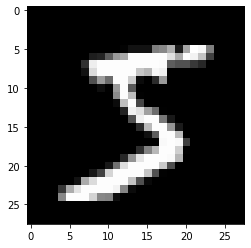

In [7]:
# Veamos una muestra
plt.imshow(x_train[0], 'gray');

In [8]:
y_train[0]

5

In [9]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Ajustamos las dimensiones de las imágenes

Para usar las imágenes en una multiplicación de matrices, esta necesita tener sólo 2 dimensiones.

In [10]:
x_train.shape

(60000, 28, 28)

In [11]:
x_train = x_train.reshape([60000, 28*28])
x_test = x_test.reshape([10000, 28*28])
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

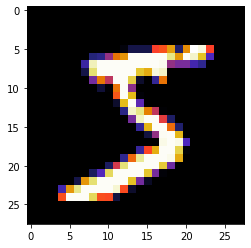

In [12]:
# Podemos usar el reshape de nuevo, para mostrar la imagen
plt.imshow(x_train[0].reshape([28,28]), 'CMRmap');

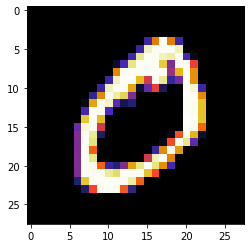

In [13]:
plt.imshow(x_train[1].reshape([28,28]), cmap='CMRmap');

## Definimos un modelo

In [14]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

from custom_callbacks import save_weights

lr = 0.01
bs = 256
nb = math.ceil(len(x_train)/bs) # Nro de batches

K.clear_session()

model = Sequential([
    Dense(128, activation='relu', input_shape=(784,)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer=SGD(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# La función de pérdida 'sparse_categorical_crossentropy' realiza la conversión
# del target a one-hot encoding.

# Guardamos los pesos del modelo para poder usarlos posteriormente al re-inicializar los pesos
save_weights(model, 'model')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


## Método de Learning rate finder

In [15]:
Çfrom custom_callbacks import LrFinder, reset_weights

lr_finder = LrFinder(nb)

model.fit(x_train, y_train, batch_size=bs, callbacks=[lr_finder]);

235/235 [==============================] - 1s 6ms/step - loss: 791.1837 - accuracy: 0.2464


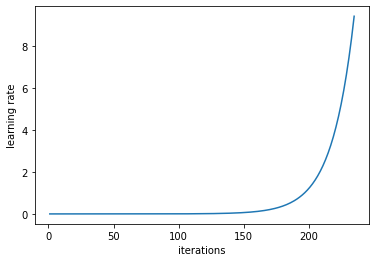

In [16]:
lr_finder.plot_lr()

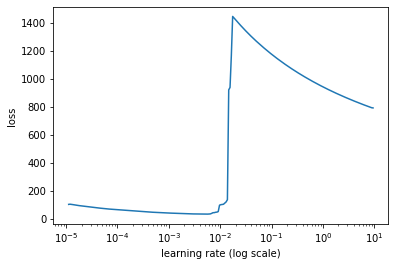

In [17]:
lr_finder.plot()

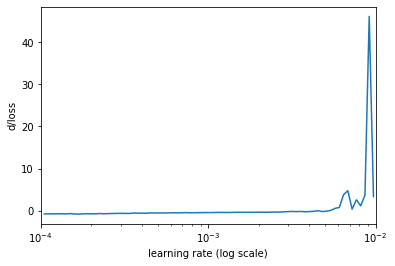

In [18]:
window_size = 1
xlim_range=[1e-4, 1e-2]

lr_finder.plot_loss_variation(window_size=window_size, xlim_range=xlim_range)

In [19]:
index_of_the_min_derivative = np.argmin(lr_finder.derivatives)

index_of_the_min_derivative

8

In [20]:
lr = lr_finder.lr_list_on_xlim[index_of_the_min_derivative]

lr

0.00016808615

## Entrenamiento

In [21]:
# Reseteamos los pesos y compilamos el modelo con el nuevo lr porque la variable ya fue sobreescrita
reset_weights(model, 'model')

model.compile(SGD(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
log = model.fit(x_train, y_train, batch_size=bs, epochs=6, validation_data=(x_test, y_test))

Epoch 1/6
235/235 [==============================] - 2s 7ms/step - loss: 9.6703 - accuracy: 0.6570 - val_loss: 3.7831 - val_accuracy: 0.7707
Epoch 2/6
235/235 [==============================] - 1s 6ms/step - loss: 3.1807 - accuracy: 0.7982 - val_loss: 2.4842 - val_accuracy: 0.8166
Epoch 3/6
235/235 [==============================] - 2s 6ms/step - loss: 2.2892 - accuracy: 0.8280 - val_loss: 1.9395 - val_accuracy: 0.8381
Epoch 4/6
235/235 [==============================] - 1s 6ms/step - loss: 1.8272 - accuracy: 0.8431 - val_loss: 1.6144 - val_accuracy: 0.8495
Epoch 5/6
235/235 [==============================] - 1s 6ms/step - loss: 1.5427 - accuracy: 0.8548 - val_loss: 1.4202 - val_accuracy: 0.8549
Epoch 6/6
235/235 [==============================] - 1s 6ms/step - loss: 1.3400 - accuracy: 0.8622 - val_loss: 1.2682 - val_accuracy: 0.8616


In [23]:
def show_results(model, log):
    loss, acc = model.evaluate(x_test, y_test, batch_size=512, verbose=False)
    print(f'Loss     = {loss:.4f}')
    print(f'Accuracy = {acc:.4f}')
    
    val_loss = log.history['val_loss']
    val_acc = log.history['val_accuracy']
        
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(val_loss, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history['accuracy'], label='train')
    ax2.plot(val_acc, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

Loss     = 1.2682
Accuracy = 0.8616


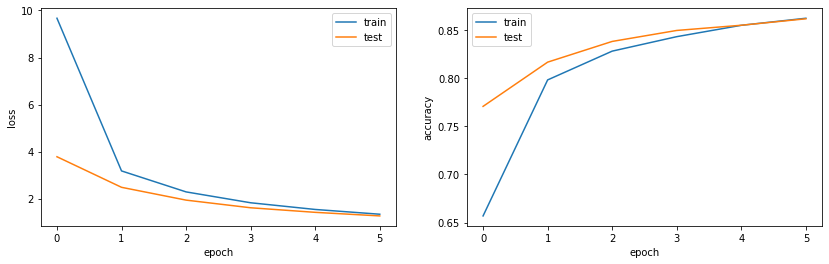

In [24]:
show_results(model, log)

## Cycling learning rates

In [25]:
from custom_callbacks import CycleLearner

cycle_learner = CycleLearner(lr, nb, n_cycle=3)

In [26]:
reset_weights(model, 'model')

log = model.fit(x_train, y_train, batch_size=bs, epochs=100,
                validation_data=(x_test, y_test), callbacks=[cycle_learner])
# La cantidad de épocas la va a controlar el callback. Cada ciclo es igual a la cantidad de batchs (nb)

Epoch 1/100
235/235 [==============================] - 2s 7ms/step - loss: 15.6459 - accuracy: 0.5986 - val_loss: 6.2700 - val_accuracy: 0.7108
Epoch 2/100
235/235 [==============================] - 2s 7ms/step - loss: 4.7020 - accuracy: 0.7547 - val_loss: 3.8982 - val_accuracy: 0.7749
Epoch 3/100
235/235 [==============================] - 2s 7ms/step - loss: 3.4417 - accuracy: 0.7918 - val_loss: 3.0171 - val_accuracy: 0.8011


Loss     = 3.0171
Accuracy = 0.8011


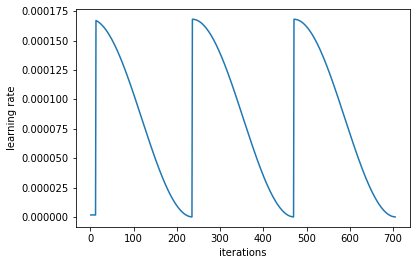

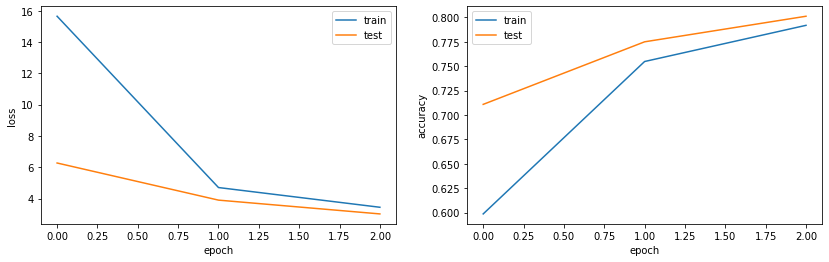

In [27]:
cycle_learner.plot_lr()
show_results(model, log)

In [28]:
reset_weights(model, 'model')

cycle_learner = CycleLearner(lr/2, nb, n_cycle=3, cycle_mult=2)
log = model.fit(x_train, y_train, batch_size=bs, epochs=100,
                validation_data=(x_test, y_test), callbacks=[cycle_learner])

Epoch 1/100
235/235 [==============================] - 2s 7ms/step - loss: 20.6130 - accuracy: 0.5057 - val_loss: 9.6491 - val_accuracy: 0.6251
Epoch 2/100
235/235 [==============================] - 2s 7ms/step - loss: 6.7920 - accuracy: 0.7003 - val_loss: 5.0710 - val_accuracy: 0.7397
Epoch 3/100
235/235 [==============================] - 2s 6ms/step - loss: 4.9389 - accuracy: 0.7487 - val_loss: 4.6441 - val_accuracy: 0.7498
Epoch 4/100
235/235 [==============================] - 2s 7ms/step - loss: 4.1489 - accuracy: 0.7713 - val_loss: 3.4180 - val_accuracy: 0.7908
Epoch 5/100
235/235 [==============================] - 2s 6ms/step - loss: 3.2984 - accuracy: 0.7992 - val_loss: 2.9430 - val_accuracy: 0.8054
Epoch 6/100
235/235 [==============================] - 2s 7ms/step - loss: 2.9528 - accuracy: 0.8101 - val_loss: 2.7831 - val_accuracy: 0.8111
Epoch 7/100
235/235 [==============================] - 2s 7ms/step - loss: 2.8487 - accuracy: 0.8132 - val_loss: 2.7587 - val_accuracy: 0.811

Loss     = 2.7587
Accuracy = 0.8116


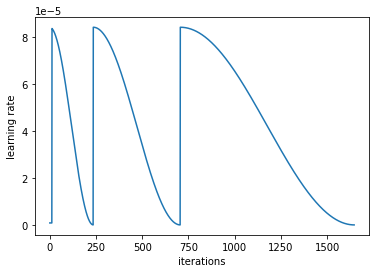

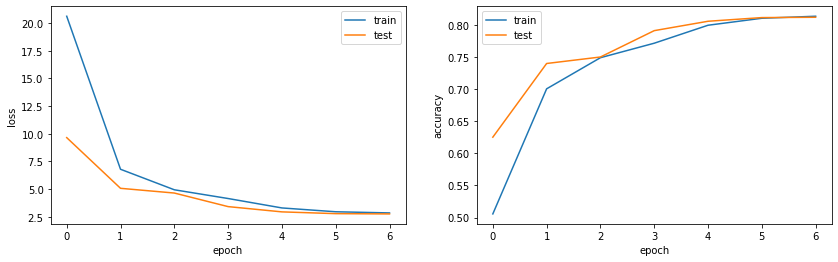

In [29]:
cycle_learner.plot_lr()
show_results(model, log)

## Snapshot ensembles

In [30]:
%mkdir -p snapshots

In [31]:
# Iniciamos el entrenamiento de forma normal
reset_weights(model, 'model')

cycle_learner = CycleLearner(lr, nb, n_cycle=3, cycle_mult=2)
log = model.fit(x_train, y_train, batch_size=bs, epochs=100,
                validation_data=(x_test, y_test), callbacks=[cycle_learner])

Epoch 1/100
235/235 [==============================] - 2s 7ms/step - loss: 15.6459 - accuracy: 0.5986 - val_loss: 6.2700 - val_accuracy: 0.7108
Epoch 2/100
235/235 [==============================] - 2s 7ms/step - loss: 4.4797 - accuracy: 0.7618 - val_loss: 3.2799 - val_accuracy: 0.7917
Epoch 3/100
235/235 [==============================] - 2s 7ms/step - loss: 3.2159 - accuracy: 0.7990 - val_loss: 3.0163 - val_accuracy: 0.8003
Epoch 4/100
235/235 [==============================] - 2s 7ms/step - loss: 2.7209 - accuracy: 0.8151 - val_loss: 2.2342 - val_accuracy: 0.8255
Epoch 5/100
235/235 [==============================] - 2s 6ms/step - loss: 2.1337 - accuracy: 0.8350 - val_loss: 1.9177 - val_accuracy: 0.8395
Epoch 6/100
235/235 [==============================] - 2s 7ms/step - loss: 1.8915 - accuracy: 0.8452 - val_loss: 1.8078 - val_accuracy: 0.8428
Epoch 7/100
235/235 [==============================] - 2s 7ms/step - loss: 1.8147 - accuracy: 0.8480 - val_loss: 1.7923 - val_accuracy: 0.843

In [32]:
# Activamos los snapshots
cycle_learner = CycleLearner(lr/2, nb, n_cycle=3, cycle_len=2, snapshots=True, snapshots_name='mnist_test')
log = model.fit(x_train, y_train, batch_size=bs, epochs=100,
                validation_data=(x_test, y_test), callbacks=[cycle_learner])

Epoch 1/100
235/235 [==============================] - 2s 7ms/step - loss: 1.7683 - accuracy: 0.8494 - val_loss: 1.6985 - val_accuracy: 0.8467
Epoch 2/100
235/235 [==============================] - 2s 7ms/step - loss: 1.6828 - accuracy: 0.8525 - val_loss: 1.6721 - val_accuracy: 0.8484
Epoch 3/100
235/235 [==============================] - 2s 7ms/step - loss: 1.6319 - accuracy: 0.8545 - val_loss: 1.5803 - val_accuracy: 0.8515
Epoch 4/100
235/235 [==============================] - 2s 7ms/step - loss: 1.5529 - accuracy: 0.8572 - val_loss: 1.5599 - val_accuracy: 0.8514
Epoch 5/100
235/235 [==============================] - 2s 6ms/step - loss: 1.5113 - accuracy: 0.8585 - val_loss: 1.4825 - val_accuracy: 0.8555
Epoch 6/100
235/235 [==============================] - 2s 7ms/step - loss: 1.4446 - accuracy: 0.8616 - val_loss: 1.4646 - val_accuracy: 0.8565


Loss     = 1.4646
Accuracy = 0.8565


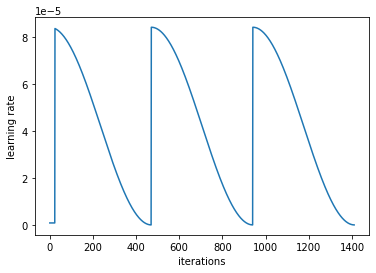

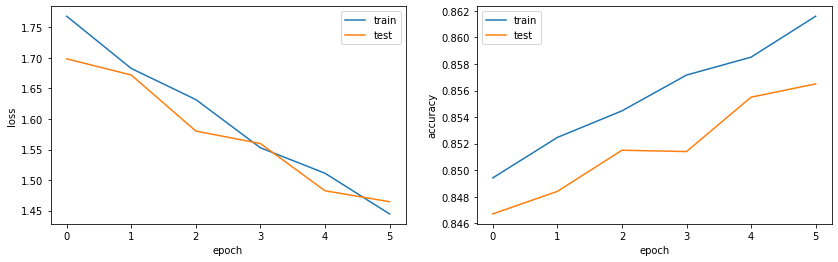

In [33]:
# Diferencia de usar "cycle_len=2" en lugar de "cycle_mult=2" en CycleLearner:
cycle_learner.plot_lr()
show_results(model, log)

In [34]:
# Archivos creados para los snapshots
snapshots = 'snapshots'
for file in os.listdir(snapshots):
    print(file)

mnist_test_1.hdf5
mnist_test_2.hdf5
mnist_test_3.hdf5


In [35]:
%ls snapshots

mnist_test_1.hdf5  mnist_test_2.hdf5  mnist_test_3.hdf5


In [36]:
# Usando snapshots
snapshots_results = np.zeros([10000,10])

for file in os.listdir(snapshots):
    model.load_weights(os.path.join(snapshots,file))
    snapshots_results += model.predict(x_test) / 3
    
acc = (snapshots_results.argmax(axis=1) == y_test).mean()
print(f'Snapshot accuracy = {acc}')

Snapshot accuracy = 0.8525
